## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [8]:
import pandas as pd
import numpy as np
import random
file = pd.read_csv("data_000637.txt")

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.



In [15]:
N  = random.randint(20000, len(pd.read_csv('data_000637.txt')))
data = pd.read_csv('data_000637.txt',nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
394760,1,0,62,3869204137,1522,12
394761,1,0,59,3869204137,1532,15
394762,1,0,139,3869204137,1535,0
394763,1,0,61,3869204137,1525,28


2\. Find out the number of BX in a ORBIT (the value 'x').

In [16]:
number = data['BX_COUNTER'].max() + 1
number

3564

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [24]:
times = data["ORBIT_CNT"]*number*25 + data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
print((times[data.index[-1]] - times[0])*10**-9,'s')

0.35370596331250004 s


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [25]:
data['abusolutetime_ns']=times
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,abusolutetime_ns
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
394760,1,0,62,3869204137,1522,12,3.447461e+14
394761,1,0,59,3869204137,1532,15,3.447461e+14
394762,1,0,139,3869204137,1535,0,3.447461e+14
394763,1,0,61,3869204137,1525,28,3.447461e+14


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [28]:
data['HEAD']=np.random.randint(0,2, size=len(data))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,abusolutetime_ns
0,1,0,123,3869200167,2374,26,3.447457e+14
1,0,0,124,3869200167,2374,27,3.447457e+14
2,0,0,63,3869200167,2553,28,3.447457e+14
3,0,0,64,3869200167,2558,19,3.447457e+14
4,0,0,64,3869200167,2760,25,3.447457e+14
...,...,...,...,...,...,...,...
394760,1,0,62,3869204137,1522,12,3.447461e+14
394761,0,0,59,3869204137,1532,15,3.447461e+14
394762,1,0,139,3869204137,1535,0,3.447461e+14
394763,0,0,61,3869204137,1525,28,3.447461e+14


6\. Create a new DataFrame that contains only the rows with HEAD=1

In [29]:
new_dataframe=data[data["HEAD"]==1]
new_dataframe

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,abusolutetime_ns
0,1,0,123,3869200167,2374,26,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
15,1,1,139,3869200167,2797,0,3.447457e+14
16,1,1,8,3869200167,2787,14,3.447457e+14
23,1,0,38,3869200167,2799,15,3.447457e+14
...,...,...,...,...,...,...,...
394757,1,0,63,3869204137,1495,18,3.447461e+14
394758,1,0,61,3869204137,1501,9,3.447461e+14
394760,1,0,62,3869204137,1522,12,3.447461e+14
394762,1,0,139,3869204137,1535,0,3.447461e+14


7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

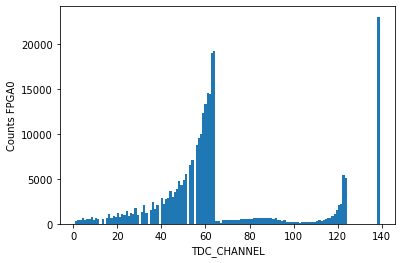

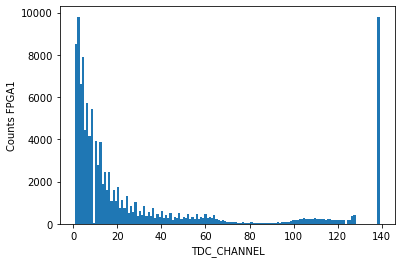

In [40]:

fpga0 = data[data['FPGA'] == 0]['TDC_CHANNEL']
fpga1 = data[data['FPGA'] == 1]['TDC_CHANNEL']

plt.xlabel("TDC_CHANNEL")
plt.ylabel("Counts FPGA0")
plt.hist(fpga0,  bins=fpga0.max())
plt.show()
plt.xlabel("TDC_CHANNEL")
plt.ylabel("Counts FPGA1")
plt.hist(fpga1,  bins=fpga1.max())
plt.show()



8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [45]:
data.groupby('TDC_CHANNEL').sum()['HEAD'].nlargest(3)

TDC_CHANNEL
139    16576
64      9768
63      9595
Name: HEAD, dtype: int32

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139



In [49]:
unique_orbits=data['ORBIT_CNT'].nunique()
print(unique_orbits)
unique_orbits_tdc139 = data[data['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique()
print(unique_orbits_tdc139)

3968
3959
